In [1]:
# Based on code from https://nextjournal.com/gkoehler/pytorch-mnist.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

## Load Data

In [3]:
# Set random seed to produce repeatable results.
random_seed = 17
torch.manual_seed(random_seed)

# NVIDIA CUDA Deep Neural Network (cuDNN) library uses nondeterministic algorithms so they are disabled. 
torch.backends.cudnn.enabled = False

In [4]:
# A Tensor is a multi-dimensional matrix with elements of a single data type.
# A Dataset is an abstract class in PyTorch that allows DataLoader to iterate through a given data.
# A Dataloader takes in a dataset and a sampler (in this case not specified) and provides an iterable.

# Converts a image into a Tensor and normalizes it with mean 0.5 and standard deviation 0.5.
transform = torchvision.transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load data for training.
train_batch_size = 100
train_dataset = torchvision.datasets.MNIST('../data/', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

# Load data for testing.
test_batch_size = 100
test_dataset = torchvision.datasets.MNIST('../data/', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)

## Look at Data

In [5]:
# Load examples.
train_examples = enumerate(train_loader)
train_batch_id, (train_example_images, train_example_labels) = next(train_examples)
test_examples = enumerate(test_loader)
test_batch_id, (test_example_images, test_example_labels) = next(test_examples)

In [6]:
train_shape = train_example_images.shape
test_shape = test_example_images.shape
print("       Batch Size | Channel | Width | Height")
print(f"Train:    {train_shape[0]}     |    {train_shape[1]}    |  {train_shape[2]}   |  {train_shape[3]}")
print(f"Test :    {test_shape[0]}     |    {test_shape[1]}    |  {test_shape[2]}   |  {test_shape[3]}")

       Batch Size | Channel | Width | Height
Train:    100     |    1    |  28   |  28
Test :    100     |    1    |  28   |  28


Train Example


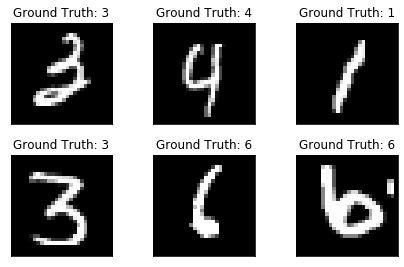

In [7]:
print("Train Example")
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(train_example_images[i][0], cmap="gray")
    plt.title(f"Ground Truth: {train_example_labels[i]}")
    plt.xticks([])
    plt.yticks([])

Test Example


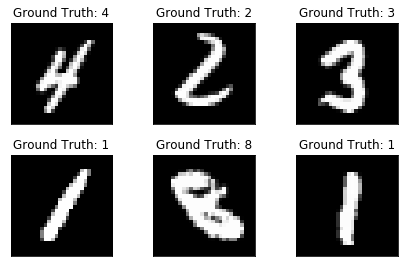

In [8]:
print("Test Example")
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(test_example_images[i][0], cmap="gray")
    plt.title(f"Ground Truth: {test_example_labels[i]}")
    plt.xticks([])
    plt.yticks([])

## Define Network

In [9]:
# Convolutional Neural Network Structure.

class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        # 2D Convolution: # input channels, # output channels, filter size.
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3, padding=1)

        # Max Pool 2D: # filter size, stride.
        self.pool1 = nn.MaxPool2d(3, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Fully Connected Layer: # input channels, # output channels.
        self.fc1 = nn.Linear(320, 80)
        self.fc2 = nn.Linear(80, 10)

    def forward(self, x):
        
        # Conv -> ReLu -> MaxPool.
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        
        # Flatten.
        x = x.view(-1, 320)
        
        # FC -> Relu.
        x = F.relu(self.fc1(x))
        
        # Softmax returns probability of each element in the vector between 0 - 1. 
        # Final Layer: FC -> Log Softmax.
        x = F.log_softmax(self.fc2(x), dim=1)
        
        return x

## Define Optimizer

In [10]:
# Optimizer as the name suggests defines how to optimize the model at each iteration.

# Basically step size: how much you want to adjust the weights at each iteration.
learning_rate = 0.01

# How much of the previous update gets applied in current update.
momentum = 0.5

# Stochastic Gradient Descent.
network = CNN()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

## Define Hyperparameters

In [11]:
n_epochs = 10
log_interval = 10

train_losses = []
train_counter = []

test_losses = []
test_counter = [i * len(train_dataset) for i in range(n_epochs + 1)]

## Define Train Step

In [12]:
def train(epoch):
    
    # Set module to training mode.
    network.train()
    
    for train_batch_id, (train_images, train_labels) in enumerate(train_loader):
        
        # Sets the gradient to zero.
        optimizer.zero_grad()
        
        # Run CNN.
        output = network(train_images)
        
        # Calculate loss.
        # Likelihood: multiply probability class vector with actual label.
        # ex) Prediction: [0.1, 0.3, 0.5, 0.1], Ground Truth: [0, 0, 1, 0]
        # ex) Likelihood: 0.1 * 0 + 0.3 * 0 + 0.5 * 1 + 0.1 * 0 = 0.5
        # Log(1) is 0 and log(negative) = negative. 
        # Negative log gives you a bigger number as likelihood gets closer to 0.
        loss = F.nll_loss(output, train_labels)
        
        # Computes gradient for every parameter which has requires_grad set to True.
        loss.backward()
        
        # Performs parameter update.
        optimizer.step()
        
        if (train_batch_id + 1) % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, str((train_batch_id + 1) * train_batch_size).rjust(6), len(train_dataset),
                100.0 * (train_batch_id + 1) * train_batch_size / len(train_dataset), loss.item()))
            
            # Append loss and counter.
            train_losses.append(loss.item())
            train_counter.append(((train_batch_id + 1) * train_batch_size) + ((epoch - 1) * len(train_dataset)))
            
            # Save internal state
            torch.save(network.state_dict(), '../results/model.pth')
            torch.save(optimizer.state_dict(), '../results/optimizer.pth')

## Define Test Step

In [13]:
def test():
    
    # Set module to evaluation mode.
    network.eval()
    
    test_loss = 0
    num_correct = 0
    
    # Temporarily sets all requires_grad to false.
    with torch.no_grad():
        for test_images, test_labels in test_loader:
            
            # Run CNN.
            output = network(test_images)
            
            # Calculate sum of loss in batch.
            test_loss += F.nll_loss(output, test_labels, reduction="sum").item()
            pred = output.data.max(1, keepdim=True)[1]
            num_correct += pred.eq(test_labels.data.view_as(pred)).sum()
        
        
    test_loss /= len(test_dataset)
    test_losses.append(test_loss)
        
    print('\nTest Set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, num_correct, len(test_dataset),
        100.0 * num_correct / len(test_dataset)))

## Train and Test Model

In [14]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test Set: Avg. loss: 2.3089, Accuracy: 1029/10000 (10%)

Train Epoch: 1 [  1000/60000 (2%)]	Loss: 2.288689
Train Epoch: 1 [  2000/60000 (3%)]	Loss: 2.304722
Train Epoch: 1 [  3000/60000 (5%)]	Loss: 2.272488
Train Epoch: 1 [  4000/60000 (7%)]	Loss: 2.291072
Train Epoch: 1 [  5000/60000 (8%)]	Loss: 2.271198
Train Epoch: 1 [  6000/60000 (10%)]	Loss: 2.273469
Train Epoch: 1 [  7000/60000 (12%)]	Loss: 2.268804
Train Epoch: 1 [  8000/60000 (13%)]	Loss: 2.257021
Train Epoch: 1 [  9000/60000 (15%)]	Loss: 2.238594
Train Epoch: 1 [ 10000/60000 (17%)]	Loss: 2.229197
Train Epoch: 1 [ 11000/60000 (18%)]	Loss: 2.208194
Train Epoch: 1 [ 12000/60000 (20%)]	Loss: 2.205839
Train Epoch: 1 [ 13000/60000 (22%)]	Loss: 2.172714
Train Epoch: 1 [ 14000/60000 (23%)]	Loss: 2.141902
Train Epoch: 1 [ 15000/60000 (25%)]	Loss: 2.123672
Train Epoch: 1 [ 16000/60000 (27%)]	Loss: 2.113586
Train Epoch: 1 [ 17000/60000 (28%)]	Loss: 2.072506
Train Epoch: 1 [ 18000/60000 (30%)]	Loss: 1.976377
Train Epoch: 1 [ 19000/60000 

Train Epoch: 3 [ 39000/60000 (65%)]	Loss: 0.121224
Train Epoch: 3 [ 40000/60000 (67%)]	Loss: 0.048237
Train Epoch: 3 [ 41000/60000 (68%)]	Loss: 0.208053
Train Epoch: 3 [ 42000/60000 (70%)]	Loss: 0.152795
Train Epoch: 3 [ 43000/60000 (72%)]	Loss: 0.145507
Train Epoch: 3 [ 44000/60000 (73%)]	Loss: 0.180968
Train Epoch: 3 [ 45000/60000 (75%)]	Loss: 0.109231
Train Epoch: 3 [ 46000/60000 (77%)]	Loss: 0.249867
Train Epoch: 3 [ 47000/60000 (78%)]	Loss: 0.117842
Train Epoch: 3 [ 48000/60000 (80%)]	Loss: 0.041425
Train Epoch: 3 [ 49000/60000 (82%)]	Loss: 0.082013
Train Epoch: 3 [ 50000/60000 (83%)]	Loss: 0.053373
Train Epoch: 3 [ 51000/60000 (85%)]	Loss: 0.122817
Train Epoch: 3 [ 52000/60000 (87%)]	Loss: 0.076176
Train Epoch: 3 [ 53000/60000 (88%)]	Loss: 0.113579
Train Epoch: 3 [ 54000/60000 (90%)]	Loss: 0.080507
Train Epoch: 3 [ 55000/60000 (92%)]	Loss: 0.232434
Train Epoch: 3 [ 56000/60000 (93%)]	Loss: 0.105210
Train Epoch: 3 [ 57000/60000 (95%)]	Loss: 0.069088
Train Epoch: 3 [ 58000/60000 (9

Train Epoch: 6 [ 17000/60000 (28%)]	Loss: 0.068936
Train Epoch: 6 [ 18000/60000 (30%)]	Loss: 0.040004
Train Epoch: 6 [ 19000/60000 (32%)]	Loss: 0.029973
Train Epoch: 6 [ 20000/60000 (33%)]	Loss: 0.067066
Train Epoch: 6 [ 21000/60000 (35%)]	Loss: 0.060208
Train Epoch: 6 [ 22000/60000 (37%)]	Loss: 0.053783
Train Epoch: 6 [ 23000/60000 (38%)]	Loss: 0.113908
Train Epoch: 6 [ 24000/60000 (40%)]	Loss: 0.032666
Train Epoch: 6 [ 25000/60000 (42%)]	Loss: 0.113313
Train Epoch: 6 [ 26000/60000 (43%)]	Loss: 0.084827
Train Epoch: 6 [ 27000/60000 (45%)]	Loss: 0.150472
Train Epoch: 6 [ 28000/60000 (47%)]	Loss: 0.024281
Train Epoch: 6 [ 29000/60000 (48%)]	Loss: 0.065262
Train Epoch: 6 [ 30000/60000 (50%)]	Loss: 0.062204
Train Epoch: 6 [ 31000/60000 (52%)]	Loss: 0.039041
Train Epoch: 6 [ 32000/60000 (53%)]	Loss: 0.021495
Train Epoch: 6 [ 33000/60000 (55%)]	Loss: 0.094228
Train Epoch: 6 [ 34000/60000 (57%)]	Loss: 0.085770
Train Epoch: 6 [ 35000/60000 (58%)]	Loss: 0.067510
Train Epoch: 6 [ 36000/60000 (6

Train Epoch: 8 [ 56000/60000 (93%)]	Loss: 0.093856
Train Epoch: 8 [ 57000/60000 (95%)]	Loss: 0.121177
Train Epoch: 8 [ 58000/60000 (97%)]	Loss: 0.060498
Train Epoch: 8 [ 59000/60000 (98%)]	Loss: 0.075914
Train Epoch: 8 [ 60000/60000 (100%)]	Loss: 0.037563

Test Set: Avg. loss: 0.0546, Accuracy: 9825/10000 (98%)

Train Epoch: 9 [  1000/60000 (2%)]	Loss: 0.009891
Train Epoch: 9 [  2000/60000 (3%)]	Loss: 0.012992
Train Epoch: 9 [  3000/60000 (5%)]	Loss: 0.025651
Train Epoch: 9 [  4000/60000 (7%)]	Loss: 0.054240
Train Epoch: 9 [  5000/60000 (8%)]	Loss: 0.096020
Train Epoch: 9 [  6000/60000 (10%)]	Loss: 0.060756
Train Epoch: 9 [  7000/60000 (12%)]	Loss: 0.078113
Train Epoch: 9 [  8000/60000 (13%)]	Loss: 0.026645
Train Epoch: 9 [  9000/60000 (15%)]	Loss: 0.055476
Train Epoch: 9 [ 10000/60000 (17%)]	Loss: 0.081673
Train Epoch: 9 [ 11000/60000 (18%)]	Loss: 0.026908
Train Epoch: 9 [ 12000/60000 (20%)]	Loss: 0.086569
Train Epoch: 9 [ 13000/60000 (22%)]	Loss: 0.101584
Train Epoch: 9 [ 14000/60000

## Evaluate Model

In [15]:
print(len(train_counter))
print(len(train_losses))
print(len(test_counter))
print(len(test_losses))

600
600
11
11


Text(0, 0.5, 'negative log likelihood loss')

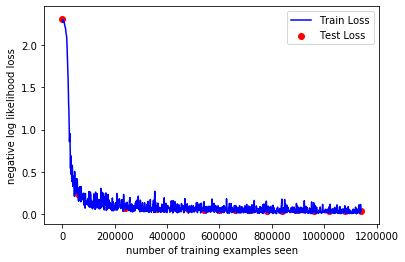

In [20]:
# Draw loss graph.
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

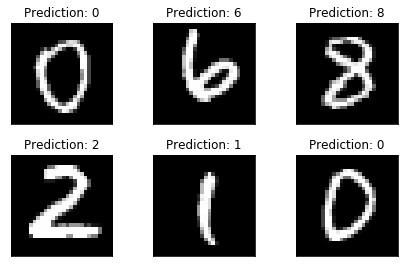

In [21]:
# Check on examples.
examples = enumerate(test_loader)
example_batch_id, (example_images, example_labels) = next(examples)

with torch.no_grad():
    output = network(example_images)
    
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_images[i][0], cmap='gray')
    plt.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])

## Example of Continued Training

In [18]:
continued_network = CNN()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

network_state_dict = torch.load("../results/model.pth")
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load("../results/optimizer.pth")
continued_optimizer.load_state_dict(optimizer_state_dict)

for i in range(11, 20):
    test_counter.append(i * len(train_dataset))
    train(i)
    test()

Train Epoch: 11 [  1000/60000 (2%)]	Loss: 0.030951
Train Epoch: 11 [  2000/60000 (3%)]	Loss: 0.072313
Train Epoch: 11 [  3000/60000 (5%)]	Loss: 0.062763
Train Epoch: 11 [  4000/60000 (7%)]	Loss: 0.027835
Train Epoch: 11 [  5000/60000 (8%)]	Loss: 0.058666
Train Epoch: 11 [  6000/60000 (10%)]	Loss: 0.074312
Train Epoch: 11 [  7000/60000 (12%)]	Loss: 0.038405
Train Epoch: 11 [  8000/60000 (13%)]	Loss: 0.011898
Train Epoch: 11 [  9000/60000 (15%)]	Loss: 0.074915
Train Epoch: 11 [ 10000/60000 (17%)]	Loss: 0.082413
Train Epoch: 11 [ 11000/60000 (18%)]	Loss: 0.057160
Train Epoch: 11 [ 12000/60000 (20%)]	Loss: 0.066005
Train Epoch: 11 [ 13000/60000 (22%)]	Loss: 0.029492
Train Epoch: 11 [ 14000/60000 (23%)]	Loss: 0.086791
Train Epoch: 11 [ 15000/60000 (25%)]	Loss: 0.063082
Train Epoch: 11 [ 16000/60000 (27%)]	Loss: 0.015893
Train Epoch: 11 [ 17000/60000 (28%)]	Loss: 0.100251
Train Epoch: 11 [ 18000/60000 (30%)]	Loss: 0.017891
Train Epoch: 11 [ 19000/60000 (32%)]	Loss: 0.032422
Train Epoch: 11 [

Train Epoch: 13 [ 37000/60000 (62%)]	Loss: 0.022586
Train Epoch: 13 [ 38000/60000 (63%)]	Loss: 0.027360
Train Epoch: 13 [ 39000/60000 (65%)]	Loss: 0.057533
Train Epoch: 13 [ 40000/60000 (67%)]	Loss: 0.075353
Train Epoch: 13 [ 41000/60000 (68%)]	Loss: 0.054756
Train Epoch: 13 [ 42000/60000 (70%)]	Loss: 0.021287
Train Epoch: 13 [ 43000/60000 (72%)]	Loss: 0.012287
Train Epoch: 13 [ 44000/60000 (73%)]	Loss: 0.040624
Train Epoch: 13 [ 45000/60000 (75%)]	Loss: 0.104697
Train Epoch: 13 [ 46000/60000 (77%)]	Loss: 0.111900
Train Epoch: 13 [ 47000/60000 (78%)]	Loss: 0.007161
Train Epoch: 13 [ 48000/60000 (80%)]	Loss: 0.033801
Train Epoch: 13 [ 49000/60000 (82%)]	Loss: 0.117671
Train Epoch: 13 [ 50000/60000 (83%)]	Loss: 0.031830
Train Epoch: 13 [ 51000/60000 (85%)]	Loss: 0.015067
Train Epoch: 13 [ 52000/60000 (87%)]	Loss: 0.029644
Train Epoch: 13 [ 53000/60000 (88%)]	Loss: 0.069340
Train Epoch: 13 [ 54000/60000 (90%)]	Loss: 0.031790
Train Epoch: 13 [ 55000/60000 (92%)]	Loss: 0.096494
Train Epoch:

Train Epoch: 16 [ 12000/60000 (20%)]	Loss: 0.074609
Train Epoch: 16 [ 13000/60000 (22%)]	Loss: 0.043837
Train Epoch: 16 [ 14000/60000 (23%)]	Loss: 0.037694
Train Epoch: 16 [ 15000/60000 (25%)]	Loss: 0.037445
Train Epoch: 16 [ 16000/60000 (27%)]	Loss: 0.015861
Train Epoch: 16 [ 17000/60000 (28%)]	Loss: 0.021194
Train Epoch: 16 [ 18000/60000 (30%)]	Loss: 0.070763
Train Epoch: 16 [ 19000/60000 (32%)]	Loss: 0.046929
Train Epoch: 16 [ 20000/60000 (33%)]	Loss: 0.025831
Train Epoch: 16 [ 21000/60000 (35%)]	Loss: 0.015320
Train Epoch: 16 [ 22000/60000 (37%)]	Loss: 0.045131
Train Epoch: 16 [ 23000/60000 (38%)]	Loss: 0.042942
Train Epoch: 16 [ 24000/60000 (40%)]	Loss: 0.157281
Train Epoch: 16 [ 25000/60000 (42%)]	Loss: 0.042733
Train Epoch: 16 [ 26000/60000 (43%)]	Loss: 0.011347
Train Epoch: 16 [ 27000/60000 (45%)]	Loss: 0.010161
Train Epoch: 16 [ 28000/60000 (47%)]	Loss: 0.019352
Train Epoch: 16 [ 29000/60000 (48%)]	Loss: 0.015515
Train Epoch: 16 [ 30000/60000 (50%)]	Loss: 0.091720
Train Epoch:

Train Epoch: 18 [ 48000/60000 (80%)]	Loss: 0.023380
Train Epoch: 18 [ 49000/60000 (82%)]	Loss: 0.059145
Train Epoch: 18 [ 50000/60000 (83%)]	Loss: 0.015423
Train Epoch: 18 [ 51000/60000 (85%)]	Loss: 0.026947
Train Epoch: 18 [ 52000/60000 (87%)]	Loss: 0.015179
Train Epoch: 18 [ 53000/60000 (88%)]	Loss: 0.011145
Train Epoch: 18 [ 54000/60000 (90%)]	Loss: 0.058597
Train Epoch: 18 [ 55000/60000 (92%)]	Loss: 0.026145
Train Epoch: 18 [ 56000/60000 (93%)]	Loss: 0.054591
Train Epoch: 18 [ 57000/60000 (95%)]	Loss: 0.017842
Train Epoch: 18 [ 58000/60000 (97%)]	Loss: 0.022105
Train Epoch: 18 [ 59000/60000 (98%)]	Loss: 0.097399
Train Epoch: 18 [ 60000/60000 (100%)]	Loss: 0.035998

Test Set: Avg. loss: 0.0370, Accuracy: 9881/10000 (99%)

Train Epoch: 19 [  1000/60000 (2%)]	Loss: 0.060774
Train Epoch: 19 [  2000/60000 (3%)]	Loss: 0.017903
Train Epoch: 19 [  3000/60000 (5%)]	Loss: 0.008281
Train Epoch: 19 [  4000/60000 (7%)]	Loss: 0.010013
Train Epoch: 19 [  5000/60000 (8%)]	Loss: 0.026314
Train Epoc